In [157]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import shapefile
from collections import Counter
from shapely.geometry import shape, Point
from matrix_factorization import *
from model_evaluations import *
from sklearn.model_selection import train_test_split
import random

%matplotlib inline

pip install geopandas didn't work and neither did the conda forge version
for some reason. I used this instead.
https://geoffboeing.com/2014/09/using-geopandas-windows/.


1. make a virtual environment with the whole anaconda: conda create --name geoproject anaconda.
2. Install wheels as so without having to do the PATH part.

3. Install shapafile with pip install pyshp. 

Geopandas is able to read all the gis files and you can change the coordinate reference system easily from it. http://matthewrocklin.com/blog/work/2017/09/21/accelerating-geopandas-1

## Prep Foursquare data from Kaggle. Categorize coordinates into their respective NYC borough by using boundary polygons from https://geo.nyu.edu/catalog/nyu-2451-34563. Coordinates not in any of these polygons are in New Jersey and will be removed.

The newly made dataframe will be saved as a pickle for fast data ingestion.

In [ ]:
# # It will take a 1-2 minutes to load because of the data parser.
# raw_fs = pd.read_csv(r'./data/original_data/dataset_TSMC2014_NYC.csv', parse_dates=['utcTimestamp'])
# # Make a coordinate tuple. This is the format that compatible with the shape file read by geopandas.
# raw_fs['coordinates'] = list(zip(raw_fs.loc[:,'longitude'], raw_fs.loc[:, 'latitude']))

# boroughs = geopandas.read_file(r'.\nyc_polygons\nyu_2451_34510.shp').to_crs({'init': 'epsg:4326'})

In [ ]:
# # Create polygon boundry objects for each borough. Needed for the function below.
# bronx = boroughs['geometry'][0]
# brooklyn = boroughs['geometry'][1]
# manhatten = boroughs['geometry'][2]
# queens = boroughs['geometry'][3]
# staten_island = boroughs['geometry'][4]



# def find_borough(coord): 
#     '''Takes coordinate point and returns which nyc borough it belongs to. The boundaries are not
#     an argument in the function so their objects must be created before the function is called.
    
#     Arguments:
#     coord -- tuple, coordinates in format (longitude, latitude).
    
#     Return -- str, the coordinated borough.'''
#     # Turn coordinate into a shapely point that can be checked if it's in a polygon.
#     point = Point(coord)
#     if bronx.contains(point) == True:
#         return 'bronx'
#     elif brooklyn.contains(point) == True:
#         return 'brooklyn'
#     elif manhatten.contains(point) == True:
#         return 'manhatten'
#     elif queens.contains(point) == True:
#         return 'queens'
#     elif staten_island.contains(point) == True:
#         return 'staten_island'
#     else:
#         return 'other'

In [ ]:
# # Create column with coordinates borough.
# raw_fs['borough'] = [find_borough(x) for x in raw_fs['coordinates']]


# # There are none's because they are in New Jersey. Take them out.
# df = raw_fs[raw_fs['borough']!='other']

# # Turn borough's column into one-hots.
# df = pd.concat([df, pd.get_dummies(df['borough'])], axis=1)

# # Make space for memory.
# del raw_fs

In [ ]:
# Save dataframe as pickle so you don't have to re-run all the code above again.
# df.to_pickle(r'.\data\cleaned_df.pkl')

In [163]:
df = pd.read_pickle(r'.\data\cleaned_df.pkl')

There are 2547 3-hour time intervals that have at least regional datapoint in this dataset. If there are no events in the time intervals when grouping, the new dataframe will skip over the no-event time interval. Since I have many dynamic features that could possibly have different missing data, I will keep doing a "left" merge to the base 2547 rows 3-hour time interval frame to I have one consistent dimension shape.

In [164]:
base_df = df.groupby(pd.Grouper(key='utcTimestamp', freq='3H'))['userId'].count().reset_index().rename(columns={'userId': 'count'})
base_df.shape

(2547, 2)

## Visitor Count: Number of unique user in region r at time interval t.

In [165]:
visitor = df.groupby([pd.Grouper(key='utcTimestamp', freq='3H'),
                      'borough'])['userId'].nunique().unstack(level=1).reset_index()
visitor_count = pd.merge(base_df, visitor, on='utcTimestamp', how='left').drop('count', axis=1).set_index('utcTimestamp')

# Make space for memory
del visitor

print('Number of time intervals: ', visitor_count.shape[0])
visitor_count.head()

Number of time intervals:  2547


,bronx,brooklyn,manhatten,queens,staten_island
utcTimestamp,,,,,
2012-04-03 18:00:00,8.0,23.0,84.0,16.0,1.0
2012-04-03 21:00:00,8.0,36.0,152.0,27.0,2.0
2012-04-04 00:00:00,13.0,30.0,108.0,16.0,4.0
2012-04-04 03:00:00,4.0,20.0,32.0,13.0,1.0
2012-04-04 06:00:00,2.0,9.0,8.0,5.0,1.0


## Observation Frequency: Number of check-ins in region r and its neighborhood at        time interval t.

In [166]:
obs = df.groupby([pd.Grouper(key='utcTimestamp', freq='3H'),
                  'borough'])['userId'].count().unstack(level=1).reset_index()
obs_freq = pd.merge(base_df, obs, on='utcTimestamp', how='left').drop('count', axis=1).set_index('utcTimestamp')

# Make space for memory
del obs

print('Number of time intervals: ', obs_freq.shape[0])   

Number of time intervals:  2547


## Visitor entropy: Diversity of visitors in a location with respect to their visits.

In [167]:
# You have do merge the user ids total number of visits to the region and then divide the 
# 2 columns to get the probability that they will be there at that time.
visits_r_t = df.groupby(['borough', pd.Grouper(key='utcTimestamp',
                                             freq='3H'), 'userId']).count().iloc[:,0]

visits_r_t.head()

borough  utcTimestamp         userId
bronx    2012-04-03 18:00:00  267       3
                              445       2
                              562       3
                              573       1
                              620       1
Name: venueId, dtype: int64

In [168]:
# number of checkins per user
total_user_checkins =df.groupby(['userId']).count().iloc[:,0]
total_user_checkins.head()

userId
1    106
2    150
3    117
4    173
5     28
Name: venueId, dtype: int64

In [169]:
# Join on user id and now you have userid number of checkins in that time interval and 
# a column that shows their total checkins.
df_visits_r_t = pd.merge(visits_r_t.reset_index(), total_user_checkins.reset_index(),
                   on=['userId']).rename(columns={'venueId_x': 'reg_time_visits',
                                                  'venueId_y': 'total_visits'})

# Make room for memory
del visits_r_t, total_user_checkins

df_visits_r_t.head()

,borough,utcTimestamp,userId,reg_time_visits,total_visits
0,bronx,2012-04-03 18:00:00,267,3,497
1,bronx,2012-04-04 03:00:00,267,3,497
2,bronx,2012-04-04 12:00:00,267,2,497
3,bronx,2012-04-05 12:00:00,267,2,497
4,bronx,2012-04-07 18:00:00,267,4,497


In [170]:
# Get the probability that user will be at region at time interval.
df_visits_r_t['probability'] = df_visits_r_t['reg_time_visits']/df_visits_r_t['total_visits']
df_visits_r_t.head()

,borough,utcTimestamp,userId,reg_time_visits,total_visits,probability
0,bronx,2012-04-03 18:00:00,267,3,497,0.006036
1,bronx,2012-04-04 03:00:00,267,3,497,0.006036
2,bronx,2012-04-04 12:00:00,267,2,497,0.004024
3,bronx,2012-04-05 12:00:00,267,2,497,0.004024
4,bronx,2012-04-07 18:00:00,267,4,497,0.008048


In [171]:
df_visits_r_t['used_for_visitor_entropy'] = [-x*np.log2(x) for x in df_visits_r_t['probability']]
df_visits_r_t.head()

,borough,utcTimestamp,userId,reg_time_visits,total_visits,probability,used_for_visitor_entropy
0,bronx,2012-04-03 18:00:00,267,3,497,0.006036,0.044500
1,bronx,2012-04-04 03:00:00,267,3,497,0.006036,0.044500
2,bronx,2012-04-04 12:00:00,267,2,497,0.004024,0.032021
3,bronx,2012-04-05 12:00:00,267,2,497,0.004024,0.032021
4,bronx,2012-04-07 18:00:00,267,4,497,0.008048,0.055993


In [172]:
# Sum all the individual user entropys for region r and time interval t.
incomplete_entropy_df = df_visits_r_t.groupby(['borough', 
                                    'utcTimestamp'])['used_for_visitor_entropy'].sum().unstack(level=0).reset_index()

visitor_entropy = pd.merge(base_df, incomplete_entropy_df, 
                           how='left', on='utcTimestamp').drop('count', axis=1).set_index('utcTimestamp')

# Make space in memory.
del incomplete_entropy_df

print('Number of time intervals: ', visitor_entropy.shape[0])
visitor_entropy.head()

Number of time intervals:  2547


,bronx,brooklyn,manhatten,queens,staten_island
utcTimestamp,,,,,
2012-04-03 18:00:00,0.425683,0.961257,4.793225,0.882073,0.041809
2012-04-03 21:00:00,0.388097,1.847471,8.960947,1.217148,0.163509
2012-04-04 00:00:00,0.607095,1.332356,6.275626,0.628272,0.201799
2012-04-04 03:00:00,0.127713,0.883753,1.768109,0.646126,0.048713
2012-04-04 06:00:00,0.112601,0.434975,0.337310,0.231435,0.028287


## Region Popularity: Assess popularity of region r at time interval t.

In [173]:
# Count how many total checkins at all time intervals 
all_checkins_at_time = df.groupby(pd.Grouper(key='utcTimestamp', freq='3H'))['userId'].count()

# Divide regions checkins at time interval by total checkins at that time interval.
region_popularity = obs_freq.divide(all_checkins_at_time, axis=0)


del all_checkins_at_time

print('Number of time intervals: ', region_popularity.shape[0])
region_popularity.head()

Number of time intervals:  2547


,bronx,brooklyn,manhatten,queens,staten_island
utcTimestamp,,,,,
2012-04-03 18:00:00,0.068627,0.176471,0.622549,0.127451,0.004902
2012-04-03 21:00:00,0.029070,0.165698,0.674419,0.119186,0.011628
2012-04-04 00:00:00,0.060000,0.188000,0.636000,0.088000,0.028000
2012-04-04 03:00:00,0.051724,0.258621,0.413793,0.258621,0.017241
2012-04-04 06:00:00,0.061224,0.469388,0.326531,0.102041,0.040816


## Visitor Ratio:


To group, count, and regroup, order by descending and take top 4


https://stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups

In [174]:
# Groupby 'userId' and 'venueId'. Count to see how many times a user checked in that venueId. This will make a series.
user_venue_count = df.groupby(['userId', 'venueId']).count().iloc[:,-1]

In [175]:
# Now that you have the count for venue checkins by each user you will re-group by 'userId' and apply a function 
# to each 'userId' grouping (sort descending and keep top 4) to get back the top 4 visited venues for that user.
user_grouping = user_venue_count.groupby(level=0, group_keys=False)  # When calling apply, add group keys argument to prevent key appearing twice IT.
user_top_venues = user_grouping.apply(lambda x: x.sort_values(ascending=False).head(4))

In [176]:
# We need the timestamp and borough of all the users top 4 checkins.
top_4_full_df = pd.merge(user_top_venues.reset_index(), df, how='left', on=['userId', 'venueId'])

# Drop duplicates so I get the first visit of the users top 4 checkins.
first_visit = top_4_full_df.drop_duplicates(['userId', 'venueId'])
incomplete_visit_df = first_visit.groupby([pd.Grouper(key='utcTimestamp', freq='3H'), 'borough']).count().iloc[:, 0].unstack(level=1)

##################### SANITY CHECK
# # All that is commented out, to make sure the time stamps are ascending since I will drop duplicates.
# # It seems like the timestamps are in order but just in case they are not I will order them because I
# # am going to remove the duplicates based on userId and venueId so it will only keep the first occurence
# # which gives up the first checkin timestamp.
# sort_df = top_4_full_df.set_index(['userId', 'venueId']).groupby(level=[0,1], group_keys=False).apply(lambda x: x.sort_values(by='utcTimestamp'))
# first_visit = sort_df.reset_index().drop_duplicates(['userId', 'venueId'])

# # Group by time stamp and borough. Take a count and unpivot the column so that we have the 
# # have the first time occurences of the top 4 userid visits by venue. The rows containing all zeros are excluded so
# # this needs to be joined back to the base df so we have a row for each time interval.
# incomplete_visit_df = first_visit.groupby([pd.TimeGrouper(key='utcTimestamp', freq='3H'), 'borough']).count().iloc[:, 0].unstack(level=1)
######################

# Join
new_user_venue_checkins = pd.merge(base_df, incomplete_visit_df.reset_index(), how='left', on='utcTimestamp').drop('count', axis=1)

# Calculate visitor ratio by dividing by observation frequency for that region at that time interval.
visitor_ratio = new_user_venue_checkins.set_index('utcTimestamp')/obs_freq

# Make space for memory.
del user_venue_count, user_grouping, user_top_venues, top_4_full_df
del first_visit,incomplete_visit_df, new_user_venue_checkins

print('Number of time intervals: ', visitor_ratio.shape[0])
visitor_ratio.head()

Number of time intervals:  2547


,bronx,brooklyn,manhatten,queens,staten_island
utcTimestamp,,,,,
2012-04-03 18:00:00,0.357143,0.277778,0.385827,0.346154,1.000000
2012-04-03 21:00:00,0.500000,0.298246,0.254310,0.341463,0.500000
2012-04-04 00:00:00,0.533333,0.276596,0.226415,0.363636,0.428571
2012-04-04 03:00:00,0.166667,0.400000,0.229167,0.300000,NaN
2012-04-04 06:00:00,NaN,0.304348,0.437500,0.400000,NaN


## All dynamic features done except for one of them. Concat them all together, do the matrix factorization (don't forget to fillna(0), and take features for the bronx.

In [177]:
all_features_df = pd.concat([visitor_count, 
           obs_freq,
           visitor_entropy,
           visitor_ratio,
           region_popularity], axis=1)

In [136]:
# Remove cities that have low observation frequency from concatentated df since they don't have much
# meaningful information. Remove cities with a mean observation frequency of less than 15.
low_checkin_cities = [city for city in obs_freq.columns if obs_freq[city].mean() < 15]

all_features_df.drop(low_checkin_cities, axis=1, inplace=True)

In [137]:
# Remove time intervals that have low activity as well. If a time interval doesn't have 
# 10*(number of regions) in the df then it will be dropped.
number_regions = all_features_df.columns.unique().shape[0]
low_activity_hours_indexes = np.where(obs_freq.drop(low_checkin_cities, axis=1).sum(axis=1) < 10*number_regions)[0]

# # Drop the low activity indexes from df.
all_features_df.drop(all_features_df.index[tuple([low_activity_hours_indexes])], axis=0, inplace=True)

Loss after epoch 0: 6921350.25359
Loss after epoch 10: 221614.92660
Loss after epoch 20: 174083.84404
Loss after epoch 30: 74740.43979
Loss after epoch 40: 34550.33034


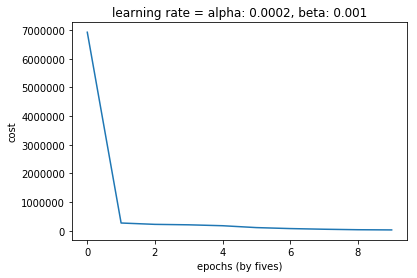

In [178]:
columns = all_features_df.columns
index = all_features_df.index

dynamic, _ = dynamic_feature_estimation(all_features_df.fillna(0).values, K=15, alpha=0.0002, beta=0.001, epochs=50, print_cost=True)

In [179]:
# To rebuild the df
dynamic_df = pd.DataFrame(dynamic, columns=columns, index=index)

In [140]:
# Get Brooklyn's dynamic features
brook_dyn = dynamic_df.loc[:, 'brooklyn']

In [141]:
##############333 Testing without the recommendation system
# brook_dyn = all_features_df.loc[:, 'brooklyn'].fillna(0)

In [142]:
# ##### There is crime data since the starting date of the dynamic features data!!!!!
# # Many of the dates in the raw file are wrong so I couldn't parse the dates from reading
# # in the file to correctly pre-process it the way I wanted it.
# raw_crime_data = pd.read_csv(r'.\data\original_data\NYPD_Complaint_Data_Historic.csv')

In [143]:
# # There are years that are wrong dates such as 1015 which will throw errors.
# # I 'coerce' the parsing and these wrong ones will turn into 'NaT'.
# raw_crime_data['Date'] = pd.to_datetime(raw_crime_data['CMPLNT_FR_DT'], format='%m/%d/%Y', errors='coerce')

# # Do the same with time and then use 'dt.time' to get just the time. There are 24:00:00 which
# # doesn't really exist so let's 'coerce' them to 'NaT' because I don't know if they are meant to be
# # on the next day or the current day of the date.
# raw_crime_data['Time'] = pd.to_datetime(raw_crime_data['CMPLNT_TO_TM'], 
#                                         format='%H:%M:%S', errors='coerce').dt.time

In [144]:
# # Drop the 'NaT''s from 'Time' and 'Date' columns
# drop_indexes_date = np.where(raw_crime_data['Date'].isnull())[0]
# drop_indexes_time = np.where(raw_crime_data['Time'].isnull())[0]


# drop_list = np.concatenate((drop_indexes_date, drop_indexes_time), axis=0)

# raw_crime_data.drop(drop_list, axis=0, inplace=True)

In [145]:
# # Filter rows from range 04-03-2012 and 02-06-2013 which is our FourSquare data range.
# raw_crime_data = raw_crime_data.set_index('Date').loc['20120403': '20130216'].sort_index()

In [146]:
# # Reset index to start combining 'Date', and 'Time' to make a timestamp.
# raw_crime_data = raw_crime_data.reset_index()

# # Couldn't figure out how to combine the 'Date' and 'Time' datetime objects together
# # so I turned them back into string and combined them.
# # I had to access 'dt' first.
# raw_crime_data['Date'] = raw_crime_data['Date'].dt.strftime('%Y-%m-%d')

# # I couldn't do this the same way as above and had to use lambda instead to get it to work.
# raw_crime_data['Time'] = raw_crime_data['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

In [147]:
# raw_crime_data['utcTimestamp'] = pd.to_datetime(raw_crime_data['Date'] + ' ' + raw_crime_data['Time'])

In [148]:
# # Grand Larceny (theft df). Theft had a low p-value in the research paper.
# theft_df = raw_crime_data[raw_crime_data['OFNS_DESC']=='GRAND LARCENY']

# del raw_crime_data

In [149]:
# theft_group = theft_df.reset_index().groupby([pd.TimeGrouper(key='utcTimestamp', freq='3H'), 'BORO_NM']).count()
# cleaned_theft_labels = theft_group.iloc[:,0].unstack(level=1).fillna(0)

# del theft_group

In [150]:
# # Save as pickle for faster loading
# pd.to_pickle(cleaned_theft_labels, r'.\data\cleaned_theft_labels.pkl')

In [151]:
theft_df = pd.read_pickle(r'.\data\cleaned_theft_labels.pkl')

# Get theft labels for brooklyn
brook_labels = theft_df['BROOKLYN']

# Our model prediction will be binary so turn labels to binary
brook_labels[brook_labels>0]=1

In [152]:
#############################333
# Joining the dynamic features and labels on the time index.
brook_df = pd.merge(brook_dyn, brook_labels.to_frame(), left_index=True, right_index=True).rename(columns={'BROOKLYN': 'labels'}).fillna(0)
print('frequency of thefts in Brooklyn: ', Counter(brook_df['labels']))

# The labels are imbalanced so I randomly make a 50%/50% label balanced dataset.
theft_keep_indexes = random.sample(population=list(np.where(brook_df['labels']==1)[0]), k=sum(brook_df['labels']==0))
non_theft_indexes = np.where(brook_df['labels']==0)[0]

# Get the indexes of the rows that I will keep for model training.
X_indexes = np.concatenate((non_theft_indexes, theft_keep_indexes), axis=0)
# sort X_indexes
X_indexes.sort()

frequency of thefts in Brooklyn:  Counter({1.0: 1253, 0.0: 96})


In [153]:
brook_df.head()

,brooklyn,brooklyn,brooklyn,brooklyn,brooklyn,labels
utcTimestamp,,,,,,
2012-04-03 18:00:00,22.456320,36.455202,0.990089,1.165996,0.113670,1.0
2012-04-03 21:00:00,34.670459,57.115800,1.666329,-1.344850,0.116877,1.0
2012-04-04 00:00:00,28.679631,47.298599,1.278413,0.440533,0.083299,1.0
2012-04-04 03:00:00,18.500079,31.483803,0.787625,1.935805,0.165540,0.0
2012-04-04 06:00:00,11.981353,21.332647,0.277404,3.066621,-0.012015,1.0


In [154]:
brook_row_filter = brook_df.iloc[X_indexes]
X = brook_row_filter.iloc[:, :5]
Y = brook_row_filter.iloc[:, -1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30)#, random_state=12)

In [155]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler().fit(X_train)
X_train_scaled = scalar.transform(X_train)
X_test_scaled = scalar.transform(X_test)

scalar = StandardScaler().fit(X)
X_scaled = scalar.transform(X)

In [162]:
# Scaling had mixed results. Not sure if I should scale because the bigger
# the distribution of randomly selected training data is influencing the 
# results even more.
svm_pred, svm_auc, svm_f1, accuracy_svm =svm_evaluation(X, Y, X_train, X_test, Y_train, Y_test)
svm_pred_s, svm_auc_s, svm_f1_s, accuracy_svm_s = svm_evaluation(X_scaled, Y, X_train_scaled, X_test_scaled, Y_train, Y_test)

lr_pred, lr_auc, lr_f1, accuracy_lr =lr_evaluation(X, Y, X_train, X_test, Y_train, Y_test)
lr_pred_s, lr_auc_s, lr_f1_s, accuracy_lr_s = lr_evaluation(X_scaled, Y, X_train_scaled, X_test_scaled, Y_train, Y_test)

rf_pred, rf_auc, rf_f1, accuracy_rf =RF_evaluation(X, Y, X_train, X_test, Y_train, Y_test)
rf_pred_s, rf_auc_s, rf_f1_s, accuracy_rf_s = RF_evaluation(X_scaled, Y, X_train_scaled, X_test_scaled, Y_train, Y_test)

TypeError: svm_evaluation() takes 4 positional arguments but 6 were given

In [159]:
# Mixed results between non-scaled and scaled features.
print('SVM')
print(' non-scaled  scaled')
print('auc: {:0.4f}, {:0.4f}'.format(svm_auc, svm_auc_s))
print(' f1: {:0.4f}, {:0.4f}'.format(svm_f1, svm_f1_s))
print('acc: {:0.4f}, {:0.4f}'.format(accuracy_svm, accuracy_svm_s))

print('\nLR')
print('non-scaled   scaled')
print('auc: {:0.4f}, {:0.4f}'.format(lr_auc, lr_auc_s))
print(' f1: {:0.4f}, {:0.4f}'.format(lr_f1,lr_f1_s))
print('acc: {:0.4f}, {:0.4f}'.format(accuracy_lr, accuracy_lr_s))

print('\nRF')
print('non-scaled   scaled')
print('auc: {:0.4f}, {:0.4f}'.format(rf_auc,rf_auc_s))
print(' f1: {:0.4f}, {:0.4f}'.format(rf_f1,rf_f1_s))
print('acc: {:0.4f}, {:0.4f}'.format(accuracy_rf, accuracy_rf_s))

SVM
 non-scaled  scaled
auc: 0.5238, 0.5512
 f1: 0.3846, 0.3913
acc: 0.4483, 0.5172

LR
non-scaled   scaled
auc: 0.7241, 0.5517
 f1: 0.7143, 0.5357
acc: 0.7241, 0.5517

RF
non-scaled   scaled
auc: 0.5232, 0.5185
 f1: 0.4815, 0.4528
acc: 0.5172, 0.5000


In [160]:
# Sum Rule
(svm_pred_s + lr_pred + rf_pred_s) / 3

array([1.        , 0.66666667, 0.        , 0.66666667, 0.33333333,
       0.        , 0.        , 0.33333333, 1.        , 0.33333333,
       0.66666667, 0.66666667, 0.66666667, 0.        , 1.        ,
       0.        , 0.        , 0.66666667, 0.        , 0.66666667,
       0.        , 0.        , 0.66666667, 0.33333333, 0.66666667,
       0.        , 0.        , 0.33333333, 0.33333333, 0.33333333,
       0.66666667, 0.66666667, 0.33333333, 0.33333333, 1.        ,
       0.        , 0.33333333, 0.        , 0.33333333, 0.        ,
       0.66666667, 0.66666667, 1.        , 0.33333333, 0.        ,
       0.        , 0.33333333, 0.33333333, 0.33333333, 0.66666667,
       1.        , 1.        , 0.        , 0.        , 0.33333333,
       0.        , 0.        , 0.        ])

In [208]:
######################################################################
# Testing some stuff out. If you take out low checkin cities and low checkin times 
# Then you can have higher results compares to just keeping everything.
from secrets import randbelow
from sklearn.preprocessing import StandardScaler
from model_evaluations_v2 import *


all_features_df = all_features_df.fillna(0)
full_dynamic_df = pd.DataFrame(dynamic, columns=columns, index=index)
theft_df = pd.read_pickle(r'.\data\cleaned_theft_labels.pkl')

# The author said the crime labels are binary so I make them binary.
theft_df[theft_df>1]=1

## Sanity check
# np.where(np.asarray(theft_df)>1)

# Get the time indexes that both X and Y df's match on, 'inner', so
# I can start deciding which city I will run the model and can then actually
# build the model.
timestamp_indexes_keep = pd.merge(full_dynamic_df, theft_df,
                                  on='utcTimestamp').index

non_dynamic_df = all_features_df.loc[timestamp_indexes_keep]
dynamic_df = full_dynamic_df.loc[timestamp_indexes_keep]
theft_df = theft_df.loc[timestamp_indexes_keep]

def neighborhood_evalution(neighborhood, neighborhood2):
    '''The neighborhoods features are used to evaluate theft predictions with 
    SVM, LR, and Random Forest and to compare original sparse features vs 
    it's dynamic features. The evaluation metrics are auc, f1, and accuracy.
    The results also compare to see if scaling the features improves results. 
    This function can be easily changed to return predictions, auc, f1, and 
    accuracy for all the differentcombinations of sparse, dynamic, 
    and scaled training data.
    
    Arguments:
    neighborhood -- str, neighborhood name located in columns dataframe.
    
    Return:
    None
    '''
    
    neighborhood_sparse_features = non_dynamic_df.loc[:, neighborhood2]
    neighborhood_dynamic_features = dynamic_df.loc[:, neighborhood2]
    neighborhood_labels = theft_df.loc[:, neighborhood]

    print('Frequency of thefts in {}: {}'.format(neighborhood, Counter(neighborhood_labels)))
    
    # The research paper uses a 50%/50% balanced set for the model
    # so I will make apply under-sampling techniques and drop some no-crime data.           
    theft_keep_indexes = np.where(neighborhood_labels==0)[0]
    non_theft_indexes = random.sample(population=list(np.where(neighborhood_labels==1)[0]), k=sum(neighborhood_labels==0))

    # Get the indexes of the rows that I will keep for model training.
    X_indexes = np.concatenate((non_theft_indexes, theft_keep_indexes), axis=0)
    # sort X_indexes
    X_indexes.sort()
    
    sparse_X = neighborhood_sparse_features.iloc[X_indexes]
    dynamic_X = neighborhood_dynamic_features.iloc[X_indexes]
    Y = neighborhood_labels.iloc[X_indexes]
    
    print('Frequency of thefts in {} after under-sampling: {}'.format(neighborhood, Counter(Y)))

    # Secured random selection which will be used to make
    # comparisons between sparse, dynamic, and scaled features.
    random_seed = randbelow(4294967000)
    X_train_sparse, X_test_sparse, Y_train, Y_test = train_test_split(sparse_X, Y, test_size=0.30, random_state=random_seed)
    X_train_dynamic, X_test_dynamic, Y_train, Y_test = train_test_split(dynamic_X, Y, test_size=0.30, random_state=random_seed)

    # Making scaled sparse features
    scalar = StandardScaler().fit(X_train_sparse)
    X_train_sparse_scaled = scalar.transform(X_train_sparse)
    X_test_sparse_scaled = scalar.transform(X_test_sparse)

    # Making scaled dynamic features
    scalar = StandardScaler().fit(X_train_dynamic)
    X_train_dynamic_scaled = scalar.transform(X_train_dynamic)
    X_test_dynamic_scaled = scalar.transform(X_test_dynamic)
    
    ### Modelling
    ## SVM
    # Sparse
    svm_sparse_pred, svm_sparse_auc, svm_sparse_f1, accuracy_sparse_svm = svm_evaluation(X_train_sparse, X_test_sparse, Y_train, Y_test)
    svm_sparse_pred_s, svm_sparse_auc_s, svm_sparse_f1_s, accuracy_sparse_svm_s =svm_evaluation(X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test)
    # Dynamic
    svm_pred, svm_auc, svm_f1, accuracy_svm =svm_evaluation(X_train_dynamic, X_test_dynamic, Y_train, Y_test)
    svm_pred_s, svm_auc_s, svm_f1_s, accuracy_svm_s = svm_evaluation(X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test)
    
    ## Logistic Regression
    # Sparse
    lr_sparse_pred, lr_sparse_auc, lr_sparse_f1, accuracy_sparse_lr = lr_evaluation(X_train_sparse, X_test_sparse, Y_train, Y_test)
    lr_sparse_pred_s, lr_sparse_auc_s, lr_sparse_f1_s, accuracy_sparse_lr_s = lr_evaluation(X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test)
    # Dynamic
    lr_pred, lr_auc, lr_f1, accuracy_lr =lr_evaluation(X_train_dynamic, X_test_dynamic, Y_train, Y_test)
    lr_pred_s, lr_auc_s, lr_f1_s, accuracy_lr_s = lr_evaluation(X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test)
    
    ## Random Forest
    # Sparse
    rf_sparse_pred, rf_sparse_auc, rf_sparse_f1, accuracy_sparse_rf =RF_evaluation(X_train_sparse, X_test_sparse, Y_train, Y_test)
    rf_sparse_pred_s, rf_sparse_auc_s, rf_sparse_f1_s, accuracy_sparse_rf_s =RF_evaluation(X_train_sparse_scaled, X_test_sparse_scaled, Y_train, Y_test)
    
    # Dynamic
    rf_pred, rf_auc, rf_f1, accuracy_rf =RF_evaluation(X_train_dynamic, X_test_dynamic, Y_train, Y_test)
    rf_pred_s, rf_auc_s, rf_f1_s, accuracy_rf_s = RF_evaluation(X_train_dynamic_scaled, X_test_dynamic_scaled, Y_train, Y_test)
    
    
    print('\n\nResults:')
    print('Dynamic Features \t\tSparse Features (Original)')
    print('')
    print('SVM')
    print(' non-scaled  scaled \t\tnon-scaled  scaled')
    print('auc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(svm_auc, svm_auc_s, svm_sparse_auc, svm_sparse_auc_s))
    print(' f1: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(svm_f1, svm_f1_s, svm_sparse_f1, svm_sparse_f1_s))
    print('acc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(accuracy_svm, accuracy_svm_s, accuracy_sparse_svm, accuracy_sparse_svm_s))

    print('\nLR')
    print(' non-scaled  scaled \t\tnon-scaled  scaled')
    print('auc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(lr_auc, lr_auc_s, lr_sparse_auc, lr_sparse_auc_s))
    print(' f1: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(lr_f1,lr_f1_s, lr_sparse_f1, lr_f1_s))
    print('acc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(accuracy_lr, accuracy_lr_s, accuracy_sparse_lr, accuracy_sparse_lr_s))

    print('\nRF')
    print('non-scaled   scaled')
    print('auc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(rf_auc,rf_auc_s, rf_sparse_auc, rf_sparse_auc_s))
    print(' f1: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(rf_f1,rf_f1_s, rf_sparse_f1, rf_sparse_f1_s))
    print('acc: {:0.4f}, {:0.4f} \t\t    {:0.4f}, {:0.4f}'.format(accuracy_rf, accuracy_rf_s, accuracy_sparse_rf, accuracy_sparse_rf_s))
    
    return None

neighborhood_evalution('BROOKLYN', 'brooklyn')

Frequency of thefts in BROOKLYN: Counter({1.0: 2342, 0.0: 194})
Frequency of thefts in BROOKLYN after under-sampling: Counter({1.0: 194, 0.0: 194})


Results:
Dynamic Features 		Sparse Features (Original)

SVM
 non-scaled  scaled 		non-scaled  scaled
auc: 0.5928, 0.5796 		    0.5618, 0.5667
 f1: 0.5000, 0.5455 		    0.4040, 0.5766
acc: 0.5726, 0.5726 		    0.4957, 0.5983

LR
 non-scaled  scaled 		non-scaled  scaled
auc: 0.4957, 0.5299 		    0.5299, 0.5128
 f1: 0.4158, 0.4660 		    0.3529, 0.4660
acc: 0.4957, 0.5299 		    0.5299, 0.5128

RF
non-scaled   scaled
auc: 0.5340, 0.5417 		    0.6111, 0.6126
 f1: 0.5124, 0.5620 		    0.5370, 0.5000
acc: 0.4957, 0.5470 		    0.5726, 0.5556


In [ ]:
###################################################
from surprise import SVD
from surprise import Dataset
from surprise import Reader
test = all_features_df.unstack().reset_index(name='value')
test = test.rename(columns={'level_0': 'borough','0': 'value'})
test = test.reindex(columns=['utcTimestamp', 'borough', 'value']).fillna(0)
min_val =test.min()[2]
max_val = test.max()[2]
reader = Reader(line_format='user item rating', rating_scale=(min_val, max_val))

data = Dataset.load_from_df(test[['utcTimestamp', 'borough', 'value']],reader=reader)

In [ ]:
test.tail()

In [ ]:
trainingset = data.build_full_trainset()

In [ ]:
algo = SVD(n_factors=20, biased=False)
algo.fit(trainingset)

In [ ]:
matrix1 = algo.pu
matrix2 =algo.qi
pd.DataFrame(np.dot(matrix1, matrix2.T)).head()
matrix2.shape

In [ ]:
all_features_df.tail()

In [ ]:
###################################################
all_features_df = pd.concat([visitor_count, 
           obs_freq,
           visitor_entropy,
           visitor_ratio,
           region_popularity], axis=1)

bronx = all_features_df.loc[:, 'bronx']
bronx.apply(lambda x: x-bronx.mean(axis=1)).values

bronx.iloc[:, :]
new, _ = dynamic_feature_estimation(all_features_df.fillna(0).values, K=20, alpha=0.0001, beta=0.001, epochs=100, print_cost=True)

In [ ]:
all_features_df.groupby('bronx')

In [ ]:
all_features_df.loc['2013-01-01 00:00:00'::]

In [ ]:
new

In [ ]:
#############
test = np.asarray(visitor_entropy.fillna(0))
test

In [ ]:
test_model, _ = dynamic_feature_estimation(test, K=3, alpha=0.00001, beta=0.001, epochs=100, print_cost=True)

In [ ]:
pd.DataFrame(test_model, columns=['nyc', '2', '3', '4', '5'])

In [ ]:
import shapefile
from shapely.geometry import shape, Point
# To install shapely
# https://gis.stackexchange.com/questions/38899/geos-and-shapely-installation-on-windows/132743#132743
# Download wheel file for the version of python that you use.
# https://www.lfd.uci.edu/~gohlke/pythonlibs/#shapely
# cd into the location of the wheel file
# pip install wheel
# pip install name_of_wheel_file.whl

# read fileshape
r = shapefile.Reader(r"C:\Users\P\OneDrive\securitas-assignment\nyu_2451_34510\nyu_2451_34510.shp")

# get the shapes
shapes = r.shapes()


# https://stackoverflow.com/questions/7861196/check-if-a-geopoint-with-latitude-and-longitude-is-within-a-shapefile
# build a shapely poolygon from your shape
p1 = shape(shapes[0])
p2 = shape(shapes[1])
p3 = shape(shapes[2])
p4 = shape(shapes[3])
p5 = shape(shapes[4])

test  = fs['longitude'][0], fs['latitude'][0]
point = Point(test)
print(point)

In [ ]:
visitor_ratio = generate_data()
region_populatiry = generate_data()
visitor_entropy = generate_data()
visitor_homogen = generate_data()
obser_freq = generate_data()
visitor_count= generate_data()

In [ ]:
visitor_count

In [ ]:
def generate_data():
    data=np.random.randint(0, 200, (2000, 1))
    data[(data<160) & (40<data)]=0
    return data